## 🔶CIFAR10 딥러닝 모델
<br> 
<br>  

## 데이터 로드 및 전처리
- CIFAR10 데이터셋을 로드하고, 훈련 데이터셋에서 20%를 검증 데이터셋으로 분리. 데이터셋은 `keras.datasets`에서 불러올 수 있는 CIFAR10 데이터 셋을 활용.  
- 데이터셋 분리 작업에서는 sklearn 라이브러리의 train_test_split 함수를 활용.
- 훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력.

In [11]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import models, layers
from tensorflow.keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import callbacks
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout


In [12]:
# cifar10 데이터셋 로드
(x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

# 훈련 데이터에서 20%를 검증 데이터로 분리
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=42)


# 훈련, 검증, 테스트 데이터와 레이블 종류가 몇개인지 출력합니다.
print("전체 학습 데이터: {} 레이블: {}".format(x_train_full.shape, y_train_full.shape))
print("학습 데이터: {} 레이블: {}".format(x_train.shape, y_train.shape))
print("검증 데이터: {} 레이블: {}".format(x_val.shape, y_val.shape))
print("테스트 데이터: {} 레이블: {}".format(x_test.shape, y_test.shape))

전체 학습 데이터: (50000, 32, 32, 3) 레이블: (50000, 1)
학습 데이터: (40000, 32, 32, 3) 레이블: (40000, 1)
검증 데이터: (10000, 32, 32, 3) 레이블: (10000, 1)
테스트 데이터: (10000, 32, 32, 3) 레이블: (10000, 1)


In [13]:
# cifar10의 분류에 해당하는 'airplane', 'automobile', 'bird', 'cat', 'deer', 
# 'dog', 'frog', 'horse', 'ship', 'truck'를 class_name으로 정의.
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

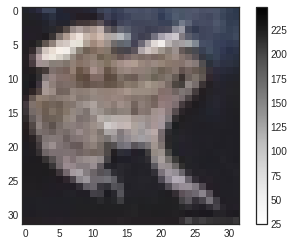

In [14]:
# 훈련 데이터의 0번째인 x_train[0]를 이미지로 시각화.
plt.style.use('seaborn-white')

plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.show()

In [15]:
# 훈련, 검증, 테스트 데이터의 형태(shape)을 출력.
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)


In [16]:
# 훈련, 검증, 테스트 데이터의 형태(shape)을 32 * 32 * 3 = 3072로 변형
x_train = x_train.reshape((x_train.shape[0], -1)) # '-1'을 사용하면 해당 차원의 크기를 자동으로 계산하여 변형
x_val = x_val.reshape((x_val.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(40000, 3072)
(10000, 3072)
(10000, 3072)


In [17]:
# 훈련, 검증, 테스트 데이터를 255로 나누어 0~1 사이의 값으로 변환합니다.
x_train = x_train / 255.
x_val = x_val / 255.
x_test = x_test / 255.

## 모델 구성 및 컴파일

- *BatchNormalization*과 *Dropout*을 적용하여 빠르게 학습하면서 과대적합을 방지하고, 10개의 이미지를 분류하는 딥러닝 모델을 구성한다.

In [32]:
model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_shape=(3072,)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               786688    
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)               

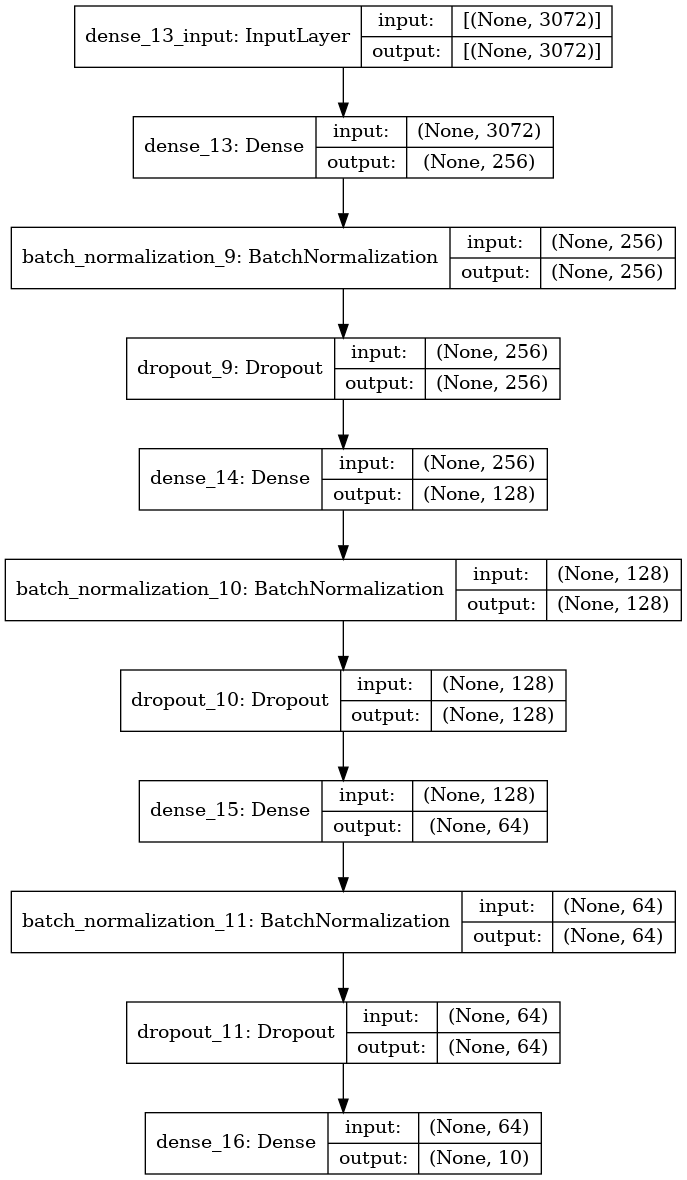

In [34]:
utils.plot_model(model, show_shapes=True)

## 모델 학습
- ModelCheckpoint와 EarlyStopping 콜백 함수를 적용하여 모델 학습을 진행

In [35]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



y_train_binary = y_train  # 이진 분류를 위해 레이블을 다시 정의
y_val_binary = y_val
y_test_binary = y_test

# 모델 학습
history = model.fit(
    x_train, y_train_binary,
    epochs=50,
    batch_size=64,
    validation_data=(x_val, y_val_binary),
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/50
625/625 [==============================] - 5s 4ms/step - loss: 2.3208 - accuracy: 0.2186 - val_loss: 1.8656 - val_accuracy: 0.3236
Epoch 2/50
625/625 [==============================] - 2s 4ms/step - loss: 1.9491 - accuracy: 0.2899 - val_loss: 1.8164 - val_accuracy: 0.3399
Epoch 3/50
625/625 [==============================] - 2s 4ms/step - loss: 1.9097 - accuracy: 0.3066 - val_loss: 1.8443 - val_accuracy: 0.3334
Epoch 4/50
625/625 [==============================] - 2s 4ms/step - loss: 1.9025 - accuracy: 0.3108 - val_loss: 1.7817 - val_accuracy: 0.3568
Epoch 5/50
625/625 [==============================] - 2s 4ms/step - loss: 1.9043 - accuracy: 0.3077 - val_loss: 1.8407 - val_accuracy: 0.3227
Epoch 6/50
625/625 [==============================] - 2s 4ms/step - loss: 1.9084 - accuracy: 0.3074 - val_loss: 1.7804 - val_accuracy: 0.3429
Epoch 7/50
625/625 [==============================] - 2s 4ms/step - loss: 1.9062 - accuracy: 0.3072 - val_loss: 2.0458 - val_accuracy: 0.2538
Epoch 

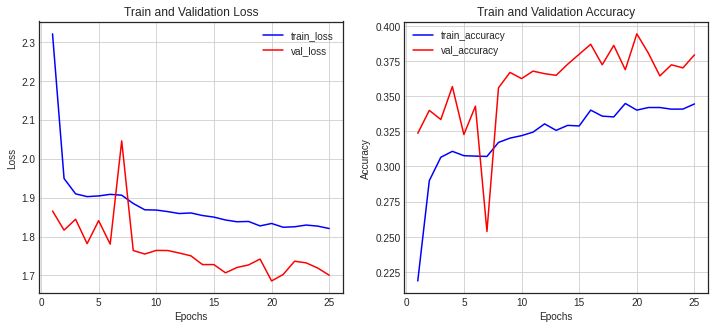

In [39]:
# 학습 히스토리의 `loss`, `val_loss`, `accuracy`, `val_accuracy`를 차트로 시각화

plt.style.use('seaborn-white')

history_dict = history.history

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')
ax1.plot(epochs, val_loss, 'r-', label='val_loss')
ax1.set_title('Train and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='train_accuracy')
ax2.plot(epochs, val_accuracy, 'r-', label='val_accuracy')
ax2.set_title('Train and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()
plt.show()

## 모델 평가 및 예측
- 테스트 데이터셋을 이용해 모델을 평가한다.

In [40]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 1.6790 - accuracy: 0.3933


[1.678995132446289, 0.39329999685287476]

<br>  

**loss는 1.6790, mae는 0.3933이 나오는 것을 확인 할 수 있다.**

<br>  
<br>  
<br>  
<br>   

---

# 회고

<br>  

- Keep  
    검색하고 찾아보며 문제를 해결하려고 노력했고 모델별로 어떤 차이인지 분류 모델인지 회귀 모델인지 생각하고 시작했다.  
    
<br>

- Problem  
    바로바로 떠오르지 않아서 가이드 없이는 여전히 진행하기에 어려움이 있다. 반복되는 코드들이 있어서 앞에서 진행했던 부분을 다시 읽어보는 등 시간을 낭비한 감이 있다.  
<br>

- Try  
    검색을 많이 해보았다.